Link to kaggle training notebook:https://www.kaggle.com/hashshes/image-colorising/notebook

Link to wandb report: https://wandb.ai/homomorfism/colorisation-images/reports/Colorization-of-images--VmlldzoxMTY0NzMz?accessToken=pob8o9wj67nxe4bhioroe2381pzna2vp7as2uhq8flg70ncz3407e73acfp2095o

Training dataset: [Bird species](https://www.kaggle.com/hashshes/image-colorising/data)

In [3]:
! wandb online

W&B online, running your script from this directory will now sync to the cloud.


In [4]:
import matplotlib.pyplot as plt
from pathlib import Path
import skimage.io as io
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from pytorch_lightning.loggers import WandbLogger
from functools import lru_cache
from random import shuffle
import random
from PIL import Image
from torch.utils.data import random_split
from easydict import EasyDict
from sklearn.model_selection import train_test_split
import torch.nn as nn
import wandb
import numpy as np
import os
from torch.optim import Adam
import torch
from torch.optim.lr_scheduler import StepLR

# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# os.environ['WANDB_API_KEY'] = user_secrets.get_secret("wandb-api")

pl.seed_everything(0)
random.seed(0)


In [5]:
config = EasyDict(
    dataset_dir=Path("../input/100-bird-species"),
    val_size=0.2,
    batch_size=64,
    lr=0.01,
    max_epochs=25,
    step_size=5,
)

In [6]:
image_ext = ['.jpg', '.JPG', '.png']

@lru_cache(maxsize=None)
def collect_images_files(path_dir: Path):
    assert path_dir.is_dir()

    images = []
    for path in path_dir.glob("**/*"):
        if path.is_file() and path.suffix in image_ext:
            images.append(path)

    print(f"Found images in {str(path_dir)}: {len(images)}")
    return sorted(images)

print(collect_images_files(config.dataset_dir)[0])

Found images in ../input/100-bird-species: 48386
../input/100-bird-species/images to test/1.jpg


Training images


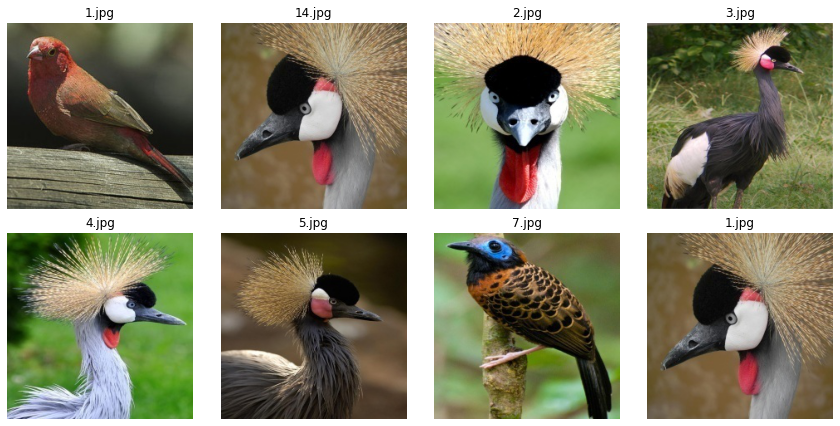

In [7]:
def visualize_dataset(dataset_dir: Path, n_rows=2, n_cols=4):
    n_samples = n_rows * n_cols
    paths = collect_images_files(dataset_dir)
#     shuffle(paths)
    figure, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 6))

    for ii, path in enumerate(paths[:n_samples]):
        image = io.imread(str(path))
        name = path.name

        ax.ravel()[ii].imshow(image)
        ax.ravel()[ii].set_title(name)
        ax.ravel()[ii].set_axis_off()

    plt.tight_layout()
    plt.show()


print("Training images")
visualize_dataset(config.dataset_dir)

In [8]:
train_transform = transforms.Compose([
#     transforms.RandomCrop(size=128),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomAffine(degrees=90, scale=(0.8, 1.2), translate=(0.1, 0.2)),
    
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

val_transform = transforms.Compose([
    transforms.RandomCrop(size=128),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

Visualizing augmented dataset


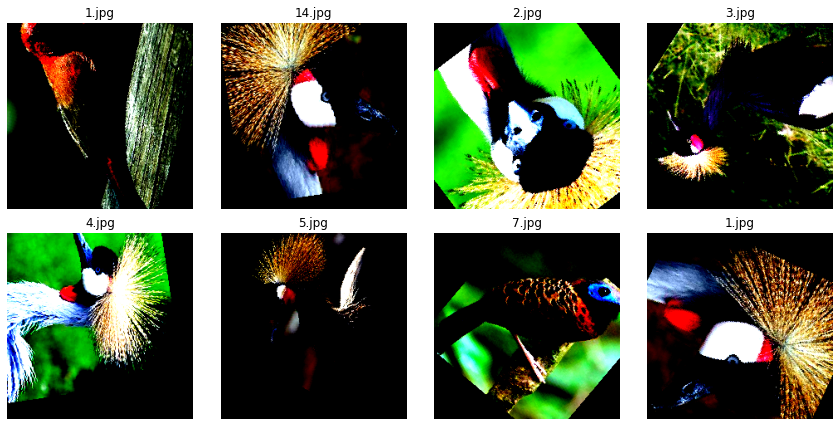

In [9]:
def visualize_augmented_dataset(dataset_dir: Path, transform, n_rows=2, n_cols=4):
    n_samples = n_rows * n_cols
    paths = collect_images_files(dataset_dir)
#     shuffle(paths)
    figure, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 6))

    for ii, path in enumerate(paths[:n_samples]):
        image = Image.open(str(path))
        image = transform(image).permute(1, 2, 0).numpy()
        name = path.name

        ax.ravel()[ii].imshow(image)
        ax.ravel()[ii].set_title(name)
        ax.ravel()[ii].set_axis_off()

    plt.tight_layout()
    plt.show()


print("Visualizing augmented dataset")
visualize_augmented_dataset(config.dataset_dir, train_transform)


In [10]:
class ImageDataset(Dataset):
    def __init__(self, data_dir: Path, transform, train: bool, val_size: float):
        super(ImageDataset, self).__init__()
        assert data_dir.is_dir()

        self.paths = sorted(collect_images_files(data_dir))

        if train:
            self.paths, _ = train_test_split(self.paths, test_size=val_size, shuffle=True, random_state=0)
        else:
            _, self.paths = train_test_split(self.paths, test_size=val_size, shuffle=True, random_state=0)

        self.transform = transform

        self.to_grayscale = transforms.Grayscale()

    def __getitem__(self, item):
        image = Image.open(str(self.paths[item]))
        image = self.transform(image)
        gray_image = self.to_grayscale(image)
        return image, gray_image

    def __len__(self):
        return len(self.paths)


class ImageDataLoader(pl.LightningDataModule):
    def __init__(self, data_dir: Path, val_size: float, batch_size: int):
        super(ImageDataLoader, self).__init__()

        self.train_dataset = ImageDataset(data_dir, train_transform, train=True, val_size=val_size)
        self.val_dataset = ImageDataset(data_dir, val_transform, train=False, val_size=val_size)

        self.batch_size = batch_size

    def train_dataloader(self):
        return DataLoader(dataset=self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(dataset=self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2)


![](https://www.run.ai/wp-content/uploads/2021/01/diagrams-Dec-2020_D-1024x816.png)

In [11]:
# input shape: torch.Size([2, 3, 224, 224])
# encoder output: torch.Size([2, 512, 14, 14])
# reconstructed shape: torch.Size([2, 3, 224, 224])

class EncoderBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int):
        super(EncoderBlock, self).__init__()
        kernel_size = (3, 3)
        
        self.block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=1, stride=stride),
            nn.BatchNorm2d(num_features=out_channels),
            nn.LeakyReLU(),
            
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(num_features=out_channels),
            nn.LeakyReLU(),
        )
        
        if stride == 1:
            self.shortcut = nn.Sequential()
        if stride == 2:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=1, stride=stride),
                nn.BatchNorm2d(num_features=out_channels),
                nn.LeakyReLU()
            )

    def forward(self, x):
        output = self.block(x)
        return output + self.shortcut(x)


class Encoder(nn.Module):

    def __init__(self):
        super(Encoder, self).__init__()

        self.preprocess = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(),
        )

        self.blocks = nn.Sequential(*[
            EncoderBlock(in_channels=64, out_channels=64, stride=2),
            EncoderBlock(in_channels=64, out_channels=64, stride=1),
            EncoderBlock(in_channels=64, out_channels=128, stride=2),
            EncoderBlock(in_channels=128, out_channels=128, stride=1),
            EncoderBlock(in_channels=128, out_channels=256, stride=2),
            EncoderBlock(in_channels=256, out_channels=256, stride=1),
            EncoderBlock(in_channels=256, out_channels=512, stride=2),
            EncoderBlock(in_channels=512, out_channels=512, stride=1),
        ])

    def forward(self, x):
        x = self.preprocess(x)
        x = self.blocks(x)
        return x

class DecoderBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, scale_factor: int):
        super(DecoderBlock, self).__init__()
        self.skip = in_channels == out_channels

        self.module = nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(),
            
            nn.ConvTranspose2d(in_channels=out_channels, out_channels=out_channels, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(),
            
            nn.Upsample(scale_factor=scale_factor),
           
        )
        
    def forward(self, x):
        x = self.module(x)
        return x


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.blocks = nn.Sequential(
            DecoderBlock(in_channels=512, out_channels=512, scale_factor=1),
            DecoderBlock(in_channels=512, out_channels=512, scale_factor=2),
            DecoderBlock(in_channels=512, out_channels=256, scale_factor=1),
            DecoderBlock(in_channels=256, out_channels=256, scale_factor=2),
            DecoderBlock(in_channels=256, out_channels=128, scale_factor=1),
            DecoderBlock(in_channels=128, out_channels=128, scale_factor=2),
            DecoderBlock(in_channels=128, out_channels=64, scale_factor=1),
            DecoderBlock(in_channels=64, out_channels=64, scale_factor=2),
            
        )

        self.postprocess = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=(3, 3), padding=(1, 1)),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.blocks(x)
        x = self.postprocess(x)
        return x

    


In [12]:
class AutoEncoder(pl.LightningModule):
    def __init__(self, conf):
        super().__init__()

        self.loss = nn.MSELoss()

        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, image):
        return self.decoder(self.encoder(image))

    def training_step(self, batch, batch_idx):
        original, gray = batch
        reconstructed = self.forward(gray)

        loss = self.loss(reconstructed, original)
        self.log("train/loss_step", loss.item())

        return {'loss': loss}

    def training_epoch_end(self, outputs):
        avg_loss = torch.hstack([loss['loss'] for loss in outputs]).mean()
        self.log('train/loss_epoch', avg_loss.item())

    def validation_step(self, batch, batch_idx):
        original, gray = batch
        reconstructed = self.forward(gray)

        loss = self.loss(reconstructed, original)
        self.log("val/loss_step", loss.item())

        return {'loss': loss}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.hstack([loss['loss'] for loss in outputs]).mean()
        self.log('val/loss_epoch', avg_loss.item())

    def configure_optimizers(self):
        optimizer = Adam(params=self.parameters(), lr=config.lr)
        lr_scheduler = StepLR(optimizer, step_size=config.step_size, gamma=0.1)
        return [optimizer,], [lr_scheduler, ] 


In [13]:
## Defining image logging

def create_grid(gray: torch.Tensor, reconstructed, original):
    gray_rgb = gray.repeat(1, 3, 1, 1)
    concat_images = torch.cat([
        torch.hstack(list(gray_rgb)),
        torch.hstack(list(reconstructed)),
        torch.hstack(list(original)),
    ], dim=2)

    return make_grid(concat_images)


class ImageCallback(pl.Callback):
    def __init__(self, train_dataloader: DataLoader, val_dataloader: DataLoader):
        super(ImageCallback, self).__init__()

        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        
        
    def on_train_epoch_end(self, trainer: pl.Trainer, pl_module: pl.LightningModule) -> None:
        original, gray = next(iter(self.train_dataloader))
        original = original.cuda()
        gray = gray.cuda()
        reconstructed = pl_module(gray)

        grid = create_grid(gray, reconstructed, original)

        grid = np.transpose(grid.cpu().detach().numpy(), axes=(1, 2, 0))

        trainer.logger.experiment.log({
            "train/predictions": wandb.Image(grid, caption="gray/reconstructed/original"),
            'global_step': trainer.global_step
        })


    def on_validation_epoch_end(self, trainer: pl.Trainer, pl_module: pl.LightningModule) -> None:
        original, gray = next(iter(self.val_dataloader))
        original = original.cuda()
        gray = gray.cuda()
        reconstructed = pl_module(gray)

        grid = create_grid(gray, reconstructed, original)

        grid = np.transpose(grid.cpu().detach().numpy(), axes=(1, 2, 0))

        trainer.logger.experiment.log({
            "val/predictions": wandb.Image(grid, caption="gray/reconstructed/original"),
            'global_step': trainer.global_step
        })



In [ ]:
def train():
    wandb.init(config=config)

    dataloader = ImageDataLoader(
        batch_size=config.batch_size,
        val_size=config.val_size,
        data_dir=config.dataset_dir
    )
    train_dataloader, val_dataloader = dataloader.train_dataloader(), dataloader.val_dataloader()
    image_callback = ImageCallback(train_dataloader, val_dataloader)
    lr_callback = pl.callbacks.LearningRateMonitor(logging_interval='step')

    model_checkpoint = pl.callbacks.ModelCheckpoint(
        save_last=True,
        save_top_k=1,
        every_n_epochs=1,
        save_weights_only=True,
    )


    logger = WandbLogger(project="TmpColorizingImages",
                         name="initial_experiment",
                         log_model='all',
                         config=config.__dict__, )

    trainer = pl.Trainer(
        logger=logger,
        gpus=1,
        max_epochs=config.max_epochs,
#         limit_train_batches=2,
#         limit_val_batches=2,
        callbacks=[image_callback, lr_callback, model_checkpoint]
    )

    model = AutoEncoder(config)
    trainer.fit(model, train_dataloader, val_dataloader)
    trainer.save_checkpoint("last.ckpt", weights_only=True)


train()


wandb: Currently logged in as: homomorfism (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:433: UserWarning: ModelCheckpoint(save_last=True, save_top_k=None, monitor=None) is a redundant configuration. You can save the last checkpoint with ModelCheckpoint(save_top_k=None, monitor=None).
  "ModelCheckpoint(save_last=True, save_top_k=None, monitor=None) is a redundant configuration."

CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]